In this notebook, the downloaded daily files will be processed into a uniform 0.25 degree grid with a uniform time dimension.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
zarr_grid=xr.open_dataset('../grid.nc')

In [3]:
zarr_time=xr.open_dataset("../time.nc")
date_start=str(zarr_time.time.min().values)[:10]
date_end=str(zarr_time.time.max().values)[:10]

```
# Create time.nc as
np.array([s.to_datetime64() for s in pd.date_range('1979/1/1', '2022/12/31', freq='1D')])
import xarray as xr
zarr_ds = xr.open_zarr(store="/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr", consolidated=True)  # get data
zarr_time=zarr_ds['time']
zarr_time.time.encoding['units'] = 'days since 1900-01-01'
zarr_time.attrs['title']='UTC time at longitude 0 degrees'
zarr_time.to_netcdf("../time.nc")
```

In [4]:
# Load the functions
# standardize_chunk_float64(ds) is here
%run -i "~/indian-ocean-zarr/notebooks/functions.py"

## Chlorophyll-a

We need to do the following for each chlorophyll dataset:

* load all the daily files
* pad the dates since data do not go back to 1979
* trim the dates to the max in the zarr file
* interpolate (coarsen in this case) to the 0.25 degree grid
* save to a zarr file for chlorophyll

```
# Create regridded data files otherwise run out of memory when processing
dataid="cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D"
#dataid="cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D"
import os, fnmatch
import xarray as xr
indir = f'/home/jovyan/shared/data/copernicus/{dataid}'
outdir = f'/home/jovyan/shared/data/copernicus/{dataid}_regrid'
filenames = fnmatch.filter(os.listdir(indir), '*.nc')
for filename in filenames:
    inf = os.path.join(indir, filename)
    outf = os.path.join(outdir, filename)
    ds = xr.open_dataset(inf)
    ds = ds.rename({"latitude": "lat", "longitude": "lon"})
    ds_interp = ds.interp_like(zarr_grid).compute()
    ds_interp.to_netcdf(outf)
```

### Load the files, process and save

In [3]:
dataid="cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_regrid"
chloro1 = xr.open_mfdataset(f'~/shared/data/copernicus/{dataid}/*.nc')

In [7]:
# Fix the time
chloro1_date_start = str(chloro1.time.min().values)[:10]
chloro_interp=chloro1.sel(time=slice(chloro1_date_start, date_end))

In [8]:
# Pad time back to start of the zarr time
timepad=pd.to_datetime(chloro1.time[0].values)-pd.to_datetime(zarr_time.time[0].values)
chloro_interp = chloro_interp.pad(time=(timepad.days,0))
chloro_interp['time']=zarr_time.time.values

In [9]:
# Fix vars to be float32 and chucks to be time 100 days
# Function defined in functions.py
chloro_interp = standardize_float64(chloro_interp)
chloro_interp = standardize_chunk(chloro_interp)

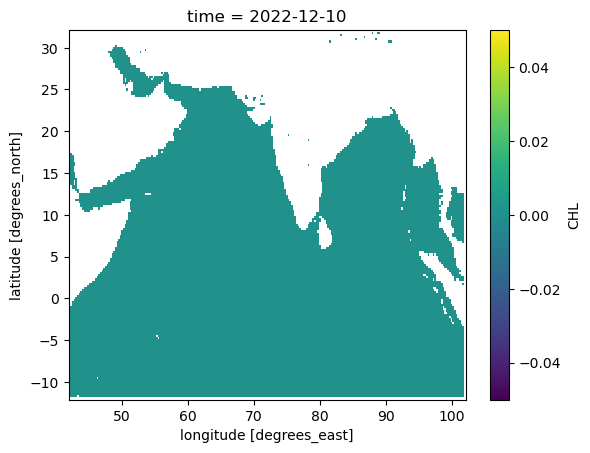

In [32]:
# Check that we did not make a mistake
(chloro_interp['CHL'].sel(time="2022-12-10")-chloro1['CHL'].sel(time="2022-12-10")).plot()

In [11]:
# fix names
chloro_interp = chloro_interp.rename({"CHL": "CHL-gapfree", "CHL_uncertainty": "CHL_uncertainty-gapfree", "flags": "CHL_flags-gapfree"})

In [12]:
from dask.distributed import Client;
client=Client(n_workers=4);
#client.close()

In [24]:
# Add full attributes to the variables
for var in chloro_interp.data_vars:
    chloro_interp[var].attrs.update(chloro_interp.attrs)

In [32]:
# Save data to zarr to preserve chunks
#chloro_interp.to_zarr('~/shared/data/finalized/chlorophyll-gapfree')
chloro_interp.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr')

In [5]:
# test by opening
xr.open_zarr(f'~/shared/data/finalized/chlorophyll.zarr')

<xarray.Dataset> Size: 17GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
Data variables:
    CHL-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-level3         (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-level3   (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

### Repeat for the level 3 data

In [35]:
dataid="cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D_regrid"
chloro1 = xr.open_mfdataset(f'~/shared/data/copernicus/{dataid}/*.nc')
# Fix the time
chloro1_date_start = str(chloro1.time.min().values)[:10]
chloro_interp=chloro1.sel(time=slice(chloro1_date_start, date_end))
# Pad time back to start of the zarr time
timepad=pd.to_datetime(chloro1.time[0].values)-pd.to_datetime(zarr_time.time[0].values)
chloro_interp = chloro_interp.pad(time=(timepad.days,0))
chloro_interp['time']=zarr_time.time.values
# Fix vars to be float32 and chucks to be time 100 days
# Function defined in functions.py
chloro_interp = standardize_float64(chloro_interp)
chloro_interp = standardize_chunk(chloro_interp)
# Relabel
chloro_interp = chloro_interp.rename({"CHL": "CHL-level3", "CHL_uncertainty": "CHL_uncertainty-level3", "flags": "CHL_flags-level3"})
for var in chloro_interp.data_vars:
    chloro_interp[var].attrs.update(chloro_interp.attrs)

In [36]:
#chloro_interp.to_zarr(f'~/shared/data/finalized/chlorophyll-level3')
chloro_interp.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr', mode='a')

### Create a flag for land and clouds

2 is land, 0 is water/observed, 1 is cloud

In [162]:
ds = xr.open_zarr(f'~/shared/data/finalized/chlorophyll.zarr')
land=np.isnan(ds['CHL-level3'].mean(dim="time"))
land = land.astype('uint8')
ds['CHL-land']=land
dcloud=np.isnan(ds['CHL-level3'])
cloud = cloud.astype('uint8')
ds['CHL-cloud']=cloud+land
ds

<xarray.Dataset> Size: 17GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
Data variables:
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-level3         (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-level3   (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [168]:
vars = ['CHL-land', 'CHL-cloud']
ds = ds[vars]
ds['CHL-land'].attrs['title'] = "flag for CHL-gapfree and CHL-level3. 2 is land; 0 is water"
ds['CHL-cloud'].attrs['title'] = "flag for CHL-gapfree and CHL-level3. 0 is land; 1 is cloud; 0 is water"
ds['CHL-land'] = ds['CHL-land']*2

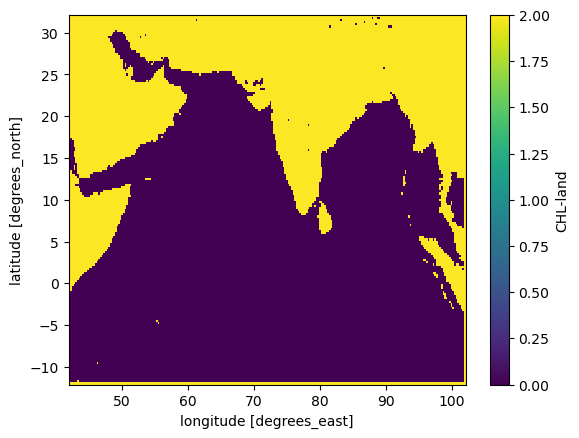

In [169]:
ds['CHL-land'].plot()

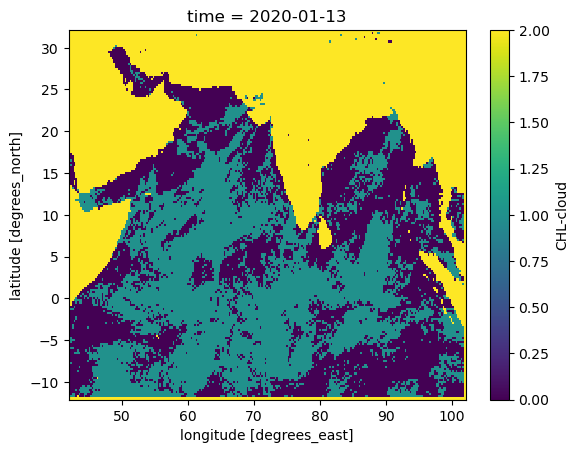

In [149]:
ds['CHL-cloud'].sel(time="2020-01-13").plot()

In [170]:
ds.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr', mode='a')

### Append variables

In [37]:
chloro_interp.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr', mode='a')

In [171]:
xr.open_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr')

<xarray.Dataset> Size: 17GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
Data variables:
    CHL-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-level3         (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-level3   (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0